In [2]:
import numpy as np
import openqcs as o
import openqcs.spinchain as sp
import openqcs.pqhs as pqhs
from openqcs.tools import color_matrix

In [3]:
a = 0.5
b = 0.5

dt = 0.01

## full system

Consider 4 site spin chain

In [4]:
def data_full(a,b,dt=0.01,n_t=100, system="sp"):

    nbits = 6
    if system=="sp":
        H = sp.H_(a,b,N=nbits,boundary="p")
    elif system=="pqhs":
        H = pqhs.H_(a,b,nbits=nbits)
    
    T = sp.T_(H, dt)
    
    rho0 = np.zeros_like(T)
    rho0[0,0] = 1.0
    rho0 = np.matrix(rho0)
    
    
    data = np.zeros((n_t,), dtype=np.double)
    for i in range(n_t):
        rho = T**i @ rho0 @(T.H)**i
        
        
        data[i] = rho[0,0].real
        
    return data

## small system

2 site spin chain

In [5]:
def data_small(a,b,dt=0.01,n_t=100,sbits=4, system="sp"):
    if system=="sp":
        H = sp.H_(a,b,N=sbits,boundary="p")
    elif system=="pqhs":
        H = pqhs.H_(a,b,nbits=sbits)
    
    T = sp.T_(H, dt)
    
    rho0 = np.zeros_like(T)
    rho0[0,0] = 1.0
    rho0 = np.matrix(rho0)
    
    
    data = np.zeros((n_t,), dtype=np.double)
    for i in range(n_t):
        rho = T**i @ rho0 @(T.H)**i
        
        data[i] = rho[0,0].real
        
    return data

## full system with hybrid method

In [6]:
def data_hybrid(a,b,dt=0.01,n_t=100,nbits=6,sbits=4, system="sp"):
    
    if nbits<sbits:
        raise ValueError()
    
    if system=="sp":
        H = sp.H_(a,b,N=nbits,boundary="p")
    elif system=="pqhs":
        H = pqhs.H_(a,b,nbits=nbits)
    
    T = sp.T_(H, dt)
    
    rho0 = np.zeros((2**sbits, 2**sbits), dtype=np.complex)
    rho0[0,0] = 1.0
    rho0 = np.matrix(rho0)
    
    data = np.zeros((n_t,), dtype=np.double)
    for i in range(n_t):
        Ks = o.get_kraus_(T**i, nbits=nbits, sys_bits=range(sbits))
        rho = o.channel_(rho0, Ks)
        
        data[i] = rho[0,0]
        
    return data

In [13]:
import matplotlib.pyplot as plt

def combine(a,b,dt=0.01,n_t=100, plot=True, system="sp", figtitle="", save=False, savetitle=""):
    
    tdata = np.arange(n_t)*dt
    fdata = data_full(a,b,dt=dt,n_t=n_t, system=system)
    sdata = data_small(a,b,dt=dt,n_t=n_t,system=system)
    hdata = data_hybrid(a,b,dt=dt,n_t=n_t, system=system)
    
    dfh = sum(np.abs(fdata-hdata)*dt)
    dfs = sum(np.abs(fdata-sdata)*dt)
    
    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(tdata, fdata, label="full system")
        plt.plot(tdata, sdata, label="small system")
        plt.plot(tdata, hdata, label="full system with hybrid method")
        plt.xlabel("$t$")
        plt.ylabel(r"$\rho_{0,0}(t)$")
        
        if figtitle != "":
            plt.title(figtitle)
        
        plt.legend()
        
        if save:
            if savetitle=="":
                plt.savefig("plot_combine.png",format="png")
            else:
                plt.savefig(savetitle+".png", format="png")
        plt.show()

        plt.figure(figsize=(10,6))
        plt.plot(tdata, fdata-hdata, label="diff hybrid & full")
        plt.plot(tdata, fdata-sdata, label="diff small & full")
        plt.xlabel("$t$")
        plt.ylabel("$\delta(t)$")
        plt.legend()
        plt.show()
    
   
        print("integrated difference:")
        print("between hybrid and full: ", dfh)
        print("between small and full: ", dfs)
    else:
        return np.abs(fdata-hdata), np.abs(fdata-sdata)

    

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


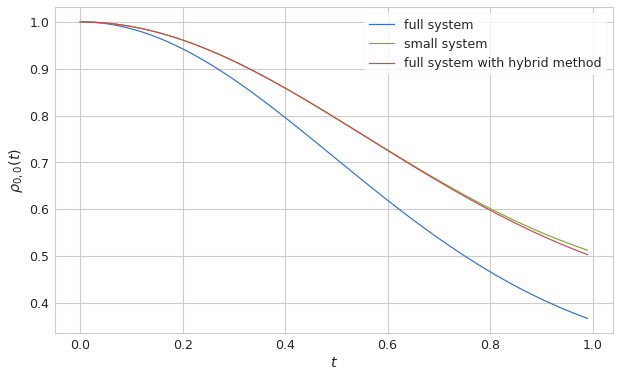

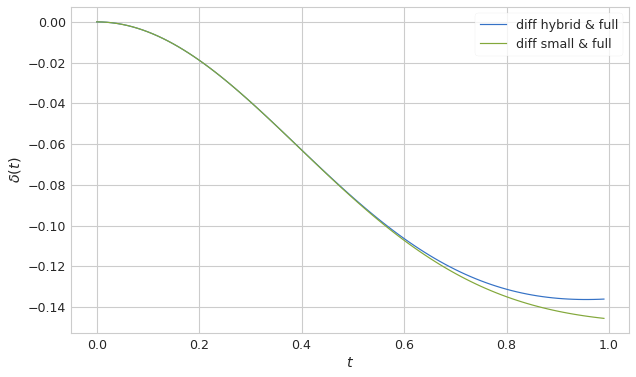

integrated difference:
between hybrid and full:  0.07683526538304931
between small and full:  0.07857108905883577


In [14]:
combine(a,b, n_t=100)

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


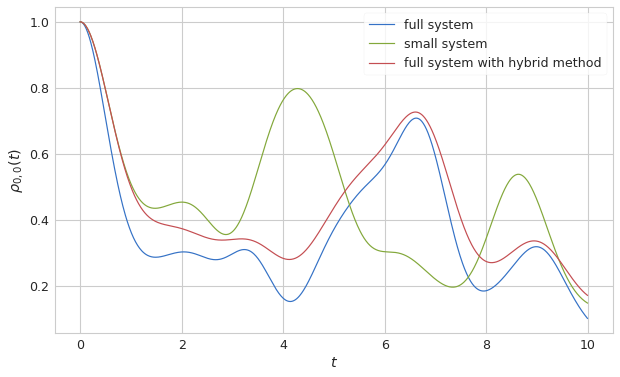

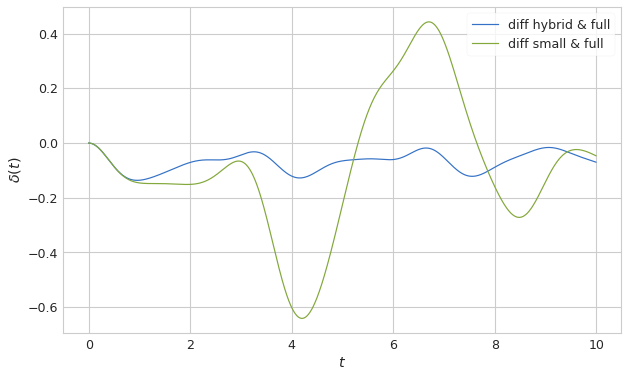

integrated difference:
between hybrid and full:  0.6899393594397529
between small and full:  2.1005450020285035


In [15]:
combine(a,b, n_t=1000)

In [16]:
Ns = np.logspace(2,4,10000, dtype=int)
N = Ns[-1]

data = np.zeros((Ns.shape[0],3),dtype=np.double)

dfh, dfs = combine(a,b,n_t=N,plot=False)

for i,n_t in enumerate(Ns):
    
    val_dfh = sum(dfh[:n_t])*dt
    val_dfs = sum(dfs[:n_t])*dt
    data[i,:] = [n_t, val_dfh, val_dfs]

    
    

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


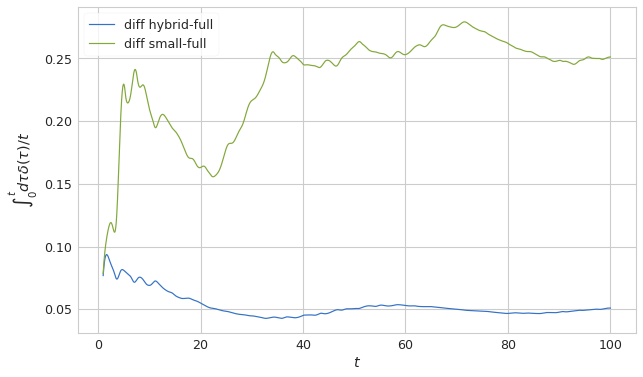

In [17]:
plt.figure(figsize=(10,6))
plt.plot(data[:,0]*dt, data[:,1]/(dt*data[:,0]), label="diff hybrid-full")
plt.plot(data[:,0]*dt, data[:,2]/(dt*data[:,0]), label="diff small-full")
plt.xlabel("$t$")
plt.ylabel(r"$\int_0^t d\tau \delta(\tau)/t$")
plt.legend()
plt.show()

## perturbed harmonic oscillator

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


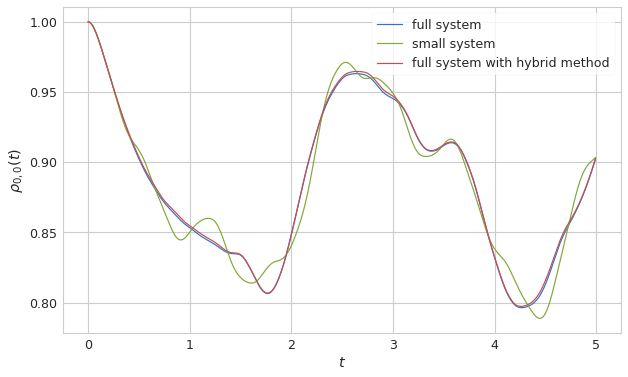

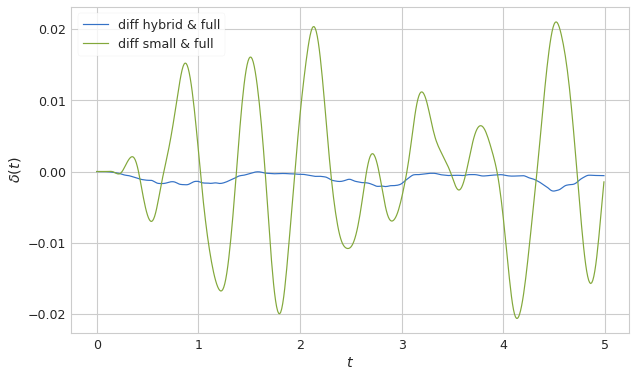

integrated difference:
between hybrid and full:  0.004875070206065838
between small and full:  0.03961756393164383


In [18]:
combine(a,b, n_t=500, system="pqhs", save=True, savetitle="motivation2")

In [25]:
Ns = np.logspace(2,4,10000, dtype=int)
N = Ns[-1]

data = np.zeros((Ns.shape[0],3),dtype=np.double)

dfh, dfs = combine(a,b,n_t=N,plot=False, system="pqhs")

for i,n_t in enumerate(Ns):
    
    val_dfh = sum(dfh[:n_t])*dt
    val_dfs = sum(dfs[:n_t])*dt
    data[i,:] = [n_t, val_dfh, val_dfs]

/home/andreas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


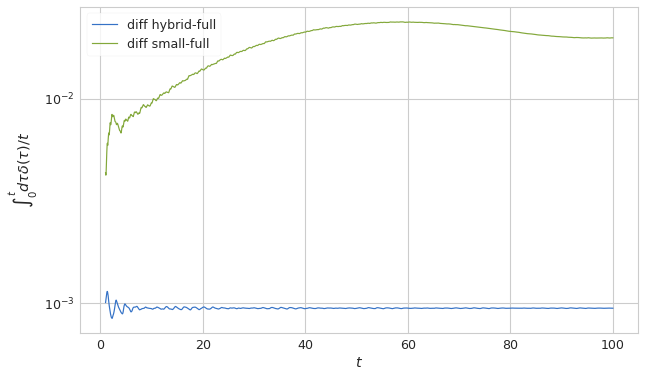

In [27]:
plt.figure(figsize=(10,6))
plt.plot(data[:,0]*dt, data[:,1]/(dt*data[:,0]), label="diff hybrid-full")
plt.plot(data[:,0]*dt, data[:,2]/(dt*data[:,0]), label="diff small-full")
plt.xlabel("$t$")
plt.ylabel(r"$\int_0^t d\tau \delta(\tau)/t$")
plt.yscale("log")
plt.legend()
plt.show()